In [19]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import os
from tqdm import tqdm
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers

In [20]:
root_path = r'/kaggle/input/animal-classification/Data/'

In [21]:
class_names = sorted(os.listdir(root_path))
print(class_names)

['Buffalo', 'Elephant', 'Rhino', 'Zebra']


In [22]:
def load_data(root_path, class_names, num_images_per_folder=200):
    data = []
    labels = []

    for name in class_names:
        folderpath = os.path.join(root_path, name)
        count = 0  # Variable to keep track of the number of images loaded for each class
        for image_name in tqdm(os.listdir(folderpath)):
            if count >= num_images_per_folder:
                break  # Stop loading images if the desired number is reached
            img = cv.imread(os.path.join(folderpath, image_name))
            img = cv.resize(img, (224, 224))
            data.append(img)
            labels.append(class_names.index(name))
            count += 1

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

data, labels = load_data(root_path, class_names, num_images_per_folder=1000)

100%|██████████| 1000/1000 [00:03<00:00, 330.65it/s]


In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming x_data contains your image data and y_data contains the corresponding labels
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)

# Normalize pixel values to be between 0 and 1
x_train_normalized = x_train.astype('float32') / 255.0
x_test_normalized = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding if not already
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Use data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a generator for the training data with data augmentation
train_generator = train_datagen.flow(x_train_normalized, y_train_one_hot, batch_size=32)

# Validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the validation data
validation_generator = validation_datagen.flow(x_test_normalized, y_test_one_hot, batch_size=32)


In [24]:
# Assuming input shape is the size of your images, adjust it accordingly
input_shape = (224,224,3)

model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(4, activation='softmax')
])


model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               77070848  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

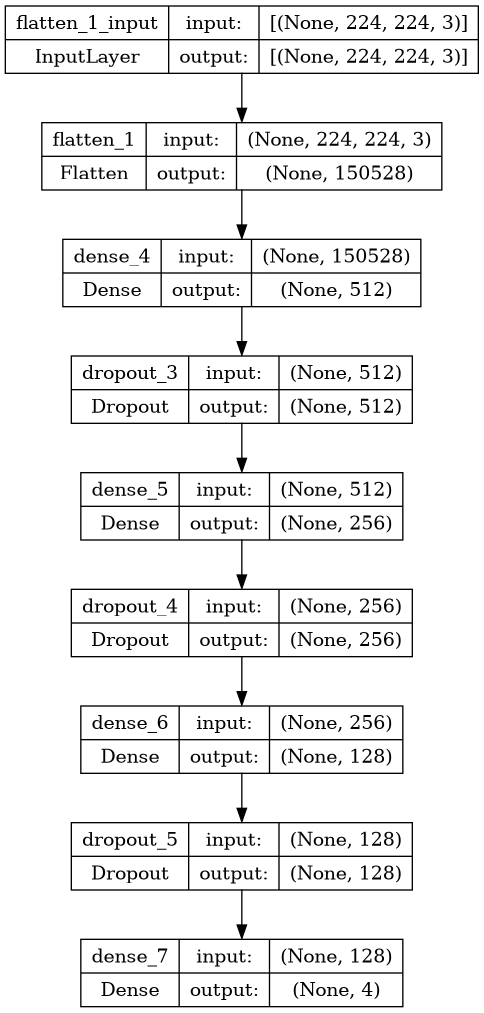

In [25]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

BATCH_SIZE = 32

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=4,          
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(x_test) // BATCH_SIZE,
    callbacks=[early_stopping]
)

Epoch 1/10
112/112 [==============================] - 39s 320ms/step - loss: 3.4317 - accuracy: 0.2581 - val_loss: 2.1156 - val_accuracy: 0.3438
Epoch 2/10
112/112 [==============================] - 35s 317ms/step - loss: 1.8165 - accuracy: 0.3069 - val_loss: 1.5733 - val_accuracy: 0.3776
Epoch 3/10
112/112 [==============================] - 36s 326ms/step - loss: 1.5144 - accuracy: 0.3344 - val_loss: 1.3975 - val_accuracy: 0.4036
Epoch 4/10
112/112 [==============================] - 36s 318ms/step - loss: 1.4141 - accuracy: 0.3299 - val_loss: 1.3448 - val_accuracy: 0.3880
Epoch 5/10
112/112 [==============================] - 35s 316ms/step - loss: 1.3653 - accuracy: 0.3374 - val_loss: 1.2980 - val_accuracy: 0.4115
Epoch 6/10
112/112 [==============================] - 35s 316ms/step - loss: 1.3473 - accuracy: 0.3416 - val_loss: 1.2975 - val_accuracy: 0.3854
Epoch 7/10
112/112 [==============================] - 36s 318ms/step - loss: 1.3375 - accuracy: 0.3571 - val_loss: 1.2936 - val_ac

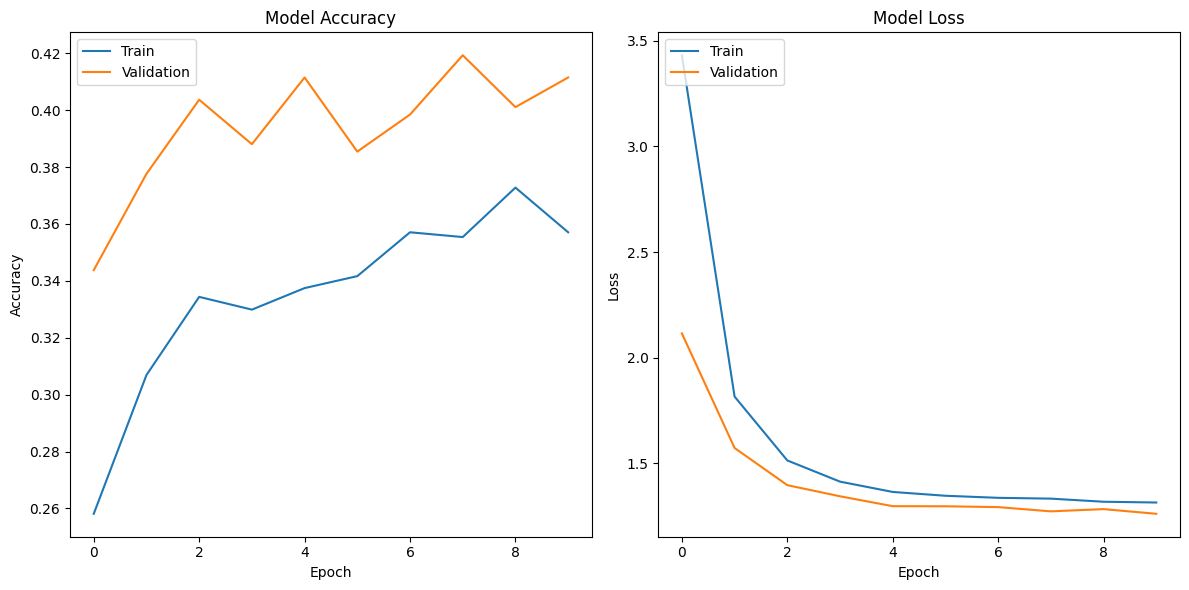

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
model.save("simple_ANN.h5")
model.save("simple_ANN.keras")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
